# 🚀 Аналіз продажів 2022: Інструкція

## Як використовувати звичайному користувачу
- **Файл даних**: Потрібен файл `MHP.csv` за шляхом `./MHP.csv` з такими колонками: `date`, `product_id`, `product_name`, `category`, `quantity`, `price`, `total_revenue`.
- **Формат даних**: Дати в форматі `YYYY-MM-DD`, числові значення (`quantity`, `price`, `total_revenue`) – позитивні.
- **Вимоги**: Python 3.x, бібліотеки `pandas`, `plotly`, `seaborn`, `matplotlib`, `scikit-learn`, `scipy`, `tabulate`.
- **Запуск**: Виконайте всі комірки (`Cell -> Run All`), щоб отримати аналіз і візуалізації.

## Що ви отримаєте
- Аналіз: продажів, сезонності, категорій.
- Прогнозування доходу на наступний місяць.
- Статистичні тести (ANOVA) для категорій.
- Інтерактивні графіки (лінії, кругові діаграми, стовпчики, бокс-плоти, теплові карти).
- Аналіз волатильності та кореляції.

# 📊 Аналіз продажів 2022: Оптимізація доходів 🛒

## Зміст
1. Попередня обробка даних
2. Аналіз продажів
3. Аналіз категорій
4. Візуалізація результатів
5. Висновки та рекомендації

**Мета**: Провести детальний аналіз продажів за 2022 рік, використовуючи лише дані з файлу MHP.csv, виявити тренди та запропонувати стратегії для зростання доходів компанії.

In [31]:
!pip install -r requirements.txt

import plotly.io as pio
pio.renderers.default = 'colab'

try:
    import pandas as pd
    import plotly
    import plotly.express as px
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    import sklearn
    from sklearn.linear_model import LinearRegression
    import scipy
    from scipy import stats
    from tabulate import tabulate
    import pkg_resources
    print("Бібліотеки успішно імпортовані!")
except ImportError as e:
    print(f"Помилка імпорту бібліотек: {e}")
    raise

print(f"Pandas version: {pd.__version__}")
print(f"Plotly version: {plotly.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Scipy version: {scipy.__version__}")
print(f"Tabulate version: {pkg_resources.get_distribution('tabulate').version}")

Бібліотеки успішно імпортовані!
Pandas version: 2.2.3
Plotly version: 6.0.0
Seaborn version: 0.13.2
Matplotlib version: 3.10.1
Scikit-learn version: 1.5.1
Scipy version: 1.13.1
Tabulate version: 0.9.0


In [32]:
def load_and_clean_data(file_path="./MHP.csv"):
    """
    Завантажує та очищує дані з CSV-файлу MHP.csv з обробкою всіх можливих помилок.
    ВАЖЛИВО !!!! Працює лише з файлом, без резервних даних. Перевіряє дублікати, пропуски, аномалії.


    Повертає:
        pd.DataFrame: Очищений DataFrame з даними.

    Викликає винятки:
        FileNotFoundError, ValueError при відсутності файлу, некоректних даних або їх недостатності.
    """
    try:
        # блок кода, де чисто теоретично виникають проблеми, спроба завантажити файл
        try:
            df = pd.read_csv(file_path)
            print(f"Файл {file_path} успішно завантажено!")
        except FileNotFoundError:
            print(f"Критична помилка: Файл {file_path} не знайдено. Створіть файл MHP.csv за вказаним шляхом і повторіть спробу.")
            raise FileNotFoundError(f"Файл {file_path} не існує.")

        # перевіряємо наявності ключових колонок
        required_columns = ['date', 'product_id', 'product_name', 'category', 'quantity', 'price', 'total_revenue']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"Критична помилка: Відсутні колонки {missing_columns}. Додайте всі необхідні колонки до файлу MHP.csv.")
            raise ValueError(f"Відсутні колонки: {missing_columns}")

        # перевіряємо на достатність даних
        if len(df) < 1:
            print("Критична помилка: Дані в файлі MHP.csv порожні або недостатні. Додайте дані до файлу.")
            raise ValueError("Дані порожні або недостатні.")
        elif len(df) < 10:
            print(f"Попередження: Дані обмежені (лише {len(df)} рядків). Використовуємо доступні дані, але аналіз може бути неточним.")

        # перевіряємо дублікатів
        duplicates = df.duplicated().sum()
        if duplicates > 0:
            print(f"Попередження: Знайдено {duplicates} дублікатів. Видаляємо їх...")
            df = df.drop_duplicates()

        # перетворення дати
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if df['date'].isnull().any():
            print("Попередження: Некоректний формат дати в деяких рядках. Замінюємо на NaT, але це може вплинути на аналіз.")
            df['date'] = df['date'].fillna(pd.NaT)
            if df['date'].isnull().all():
                print("Критична помилка: Усі дати некоректні. Виправте формат дат у файлі MHP.csv.")
                raise ValueError("Усі дати некоректні.")

        # перевіряємо на негативні значення
        negative_values = df[['quantity', 'price', 'total_revenue']].lt(0).any()
        if negative_values.any():
            print("Попередження: Знайдено негативні значення в quantity, price або total_revenue. Замінюємо на 0.")
            df[['quantity', 'price', 'total_revenue']] = df[['quantity', 'price', 'total_revenue']].clip(lower=0)

        # перевіряємо, чи total_revenue = quantity * price - це в умові прописано
        df['check_revenue'] = df['quantity'] * df['price']
        anomalies = df[df['total_revenue'] != df['check_revenue']]
        if not anomalies.empty:
            print("Попередження: Знайдено аномалії в total_revenue. Виправляємо...")
            df.loc[anomalies.index, 'total_revenue'] = df.loc[anomalies.index, 'check_revenue']

        # + додаткові колонки
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year

        # заповнюєм пропуски
        print("Пропуски в даних:", df.isnull().sum())
        if df.isnull().sum().sum() > 0:
            print("Попередження: Є пропуски в даних. Заповнюємо NaN нулями або відповідними значеннями.")
            df['quantity'] = df['quantity'].fillna(0)
            df['price'] = df['price'].fillna(df['price'].mean())
            df['total_revenue'] = df['total_revenue'].fillna(df['quantity'] * df['price'])
            df['product_name'] = df['product_name'].fillna('Unknown Product')
            df['category'] = df['category'].fillna('Unknown Category')

        # перевіряємо на мін. кільк. унікальних записів
        if df['product_name'].nunique() < 2 or df['category'].nunique() < 2:
            print("Попередження: Недостатньо унікальних продуктів або категорій для повноцінного аналізу. Додайте більше даних до файлу MHP.csv.")

        # доп. перевірка якості даних
        print("Статистика унікальності:", df[['product_name', 'category']].nunique())
        print("Розподіл доходу:", df['total_revenue'].describe())

        return df

    except Exception as e:
        print(f"Критична помилка обробки даних: {e}")
        raise

# завантажуємо дані
df = load_and_clean_data()
print("Дані успішно завантажено, очищено та підготовлено!")
print(df.head())

Файл ./MHP.csv успішно завантажено!
Пропуски в даних: date             0
product_id       0
product_name     0
category         0
quantity         0
price            0
total_revenue    0
check_revenue    0
month            0
year             0
dtype: int64
Статистика унікальності: product_name    6
category        3
dtype: int64
Розподіл доходу: count     26.000000
mean      41.038462
std       28.518739
min       12.000000
25%       20.000000
50%       30.000000
75%       54.500000
max      125.000000
Name: total_revenue, dtype: float64
Дані успішно завантажено, очищено та підготовлено!
        date  product_id product_name    category  quantity  price  \
0 2022-01-01         101    Product A  Category 1         2   10.0   
1 2022-01-02         102    Product B  Category 1         1   15.0   
2 2022-01-03         103    Product C  Category 2         5    7.0   
3 2022-01-04         104    Product D  Category 3        10    3.0   
4 2022-02-01         101    Product A  Category 1      

## 📈 Аналіз продажів

In [33]:
def analyze_sales(df):
    """
    Тут проводиться аналіз: загальних показників, топ продуктів, сезонності, кореляції та прогнозування.
    ВАЖЛИВО!!!!! Використовує лише дані з файлу MHP.csv.

    Аргументи:
        df (pd.DataFrame): Очищений DataFrame з даними.

    Повертає:
        tuple: (total_revenue, top_products, monthly_trends, correlation, sales_forecast)

    Викликає винятки:
        ValueError при недостатності даних.
    """
    try:
        if len(df) < 1:
            print("Критична помилка: Недостатньо даних для аналізу продажів. Додайте дані до файлу MHP.csv.")
            raise ValueError("Недостатньо даних для аналізу продажів.")

        # заг. показники
        total_revenue = df['total_revenue'].sum()
        if total_revenue <= 0:
            print("Критична помилка: Загальний дохід дорівнює 0 або негативний. Виправте дані в файлі MHP.csv.")
            raise ValueError("Загальний дохід не може бути 0 або негативним.")
        avg_revenue = df['total_revenue'].mean()
        print(f"📊 Загальний дохід: {total_revenue}")
        print(f"📊 Середній чек: {avg_revenue:.2f}")

        # топ продукти
        top_products = df.groupby('product_name')[['quantity', 'total_revenue']].sum().sort_values(by='total_revenue', ascending=False)
        if top_products.empty or top_products['total_revenue'].sum() == 0:
            print("Критична помилка: Недостатньо даних про продукти. Додайте дані про продукти до файлу MHP.csv.")
            raise ValueError("Недостатньо даних про продукти.")
        print("\n📈 Топ продукти за доходом і кількістю:")
        print(tabulate(top_products, headers='keys', tablefmt='pretty', floatfmt='.2f'))

        # сезонність
        monthly_trends = df.groupby('month')['total_revenue'].agg(['sum', 'mean']).rename(columns={'sum': 'Дохід', 'mean': 'Середній чек'})
        if monthly_trends['Дохід'].sum() == 0:
            print("Критична помилка: Недостатньо даних для сезонності. Додайте дані за місяцями до файлу MHP.csv.")
            raise ValueError("Недостатньо даних для сезонності.")
        print("\n📉 Сезонність:")
        print(tabulate(monthly_trends, headers='keys', tablefmt='pretty', floatfmt='.2f'))

        # кореляція
        correlation = df[['price', 'quantity', 'total_revenue']].corr()
        if correlation.isna().any().any():
            print("Попередження: Недостатньо даних для кореляції. Результати можуть бути неточними. Додайте більше даних до файлу MHP.csv.")
        print("\n📊 Кореляція між ціною, кількістю та доходом:")
        print(tabulate(correlation, headers='keys', tablefmt='pretty', floatfmt='.2f'))

        # прогнозування продажів (лінійна регресія для доходу за місяцями)
        X = monthly_trends.index.values.reshape(-1, 1)  # Місяці-(ознака)
        y = monthly_trends['Дохід'].values  # Дохід-(ціль)
        if len(X) > 1:  # перевірка, чи достатньо даних для прогнозу
            model = LinearRegression()
            model.fit(X, y)
            next_month = [[max(monthly_trends.index) + 1]]  # прогноз на наступний місяць
            forecast = model.predict(next_month)[0]
            print(f"\n💡 Прогноз доходу на наступний місяць (місяць {max(monthly_trends.index) + 1}): {forecast:.2f}")
        else:
            print("Попередження: Недостатньо даних для прогнозування. Додайте більше даних за місяцями до файлу MHP.csv.")

        # волатильність (стандартне відхилення доходу)
        volatility = monthly_trends['Дохід'].std()
        print(f"📊 Волатильність доходу за місяцями: {volatility:.2f}")

        return total_revenue, top_products, monthly_trends, correlation, forecast if len(X) > 1 else None

    except Exception as e:
        print(f"Помилка в аналізі продажів: {e}")
        raise

total_revenue, top_products, monthly_trends, correlation, sales_forecast = analyze_sales(df)

📊 Загальний дохід: 1067.0
📊 Середній чек: 41.04

📈 Топ продукти за доходом і кількістю:
+--------------+----------+---------------+
| product_name | quantity | total_revenue |
+--------------+----------+---------------+
|  Product E   |   12.0   |     240.0     |
|  Product F   |   9.0    |     225.0     |
|  Product A   |   22.0   |     220.0     |
|  Product C   |   25.0   |     175.0     |
|  Product B   |   8.0    |     120.0     |
|  Product D   |   29.0   |     87.0      |
+--------------+----------+---------------+

📉 Сезонність:
+-------+-------+--------------+
| month | Дохід | Середній чек |
+-------+-------+--------------+
|   1   | 100.0 |     25.0     |
|   2   | 110.0 |     55.0     |
|   3   | 55.0  |     27.5     |
|   4   | 89.0  |     44.5     |
|   5   | 118.0 |     59.0     |
|   6   | 89.0  |     44.5     |
|   7   | 65.0  |     32.5     |
|   8   | 52.0  |     26.0     |
|   9   | 81.0  |     40.5     |
|  10   | 185.0 |     92.5     |
|  11   | 76.0  |     38.0  

**Аналіз топ продуктів за доходом та кількістю**

- **Продукт E:** Найвищий дохід **(240.0)** при кількості 12 одиниць, ціна за одиницю ≈ 20.0. Високомаржинальний продукт.
- **Продукт F:** Дохід **225.0** при 9 одиницях, ціна ≈ 25.0 — найдорожчий продукт.
- **Продукт A:** Дохід **220.0** при 22 одиницях, ціна ≈ 10.0. Стабільний середній виконавець.
- **Продукт C:** Дохід **175.0** при 25 одиницях, ціна ≈ 7.0. Помірна продуктивність.
- **Продукт B:** Дохід **120.0** при 8 одиницях, ціна ≈ 15.0. Низька кількість проданих одиниць.
- **Продукт D:** Дохід **87.0** при 29 одиницях, ціна ≈ 3.0. Найвища кількість, але низький дохід через низьку ціну.

**Аналізуючи цю інформацію маємо:**

- У нас значна різниця в **ціні за одиницю**, від **3.0** (Product D) до **25.0** (Product F);
- **E i F Продукти** **високоприбуткові**, але продаються в менших кількостях;
- **Product D** - продукт **масового попиту** - з низькою маржею;
- **Product A** має **збалансоване співвідношення** квількості і доходу, що робить його головним продуктом для стабільного збиту/заробітку;

**Аналізуємо взаємозв'язок**

- 1. Можливо **високі ціни** (E, F) можуть бути пов'язані з **преміум-сигментом** або **меншою конкуренцією на ринку**
- 2. **Низька ціна** (D) можливо вкахує навпаки на **масовий ринок** або стратегію **"приманки"** для залучення клієнтів.

**Кореляція між ціною, кількістю і доходом**:

- **Ціна vs Кількість**: **-0.52**: помірно негативна,  зі зростанням ціни кількість проданих одиниць зменшується.
- **Ціна vs Загальний дохід**: **0.53** помірна позитивна кореляці, зростання ціни сприяє збільшенню доходу.  
- **Кількість vs Загальний дохід**: **0.29** слабка позитивна кореляція, збільшення кількості має менший вплив на дохід, ніж ціна.

З цього можемо зробити **висновок**, що **підвищуючи ціну** ми більше вплинемо на **дохід**, аніж при збільшені самої кількості проданих продуктів. Наприклад, це можливо через **нееластичність** самого  **попиту**, коли клієнт готов платити більше саме за певні продукти.

-**позитивна кореляція** скоріше пов'язана з (E, F) високоприбутковими продуктами, тому що клієнти можуть цінувати саме **якість**, **унікальність** продукту, замість кількості.

**Сезонність і тренди (за місяцями)**

📊Пікові місяці:

- **Жовтень (місяць 10)**:  
  - **Дохід**: 185.0
  - **Середній чек**: 92.5 
  - Найсильніший місяць, особливо для **Category 3 (125.0)**.  

- **Травень (місяць 5)**:  
  - **Дохід**: 118.0  
  - **Середній чек**: 59.0 
  - Пік для **Category 2 (100.0)**.  

- **Лютий (місяць 2)**:  
  - **Дохід**: 110.0  
  - **Середній чек**: 55.0  
  - Сильний для **Category 2 (80.0)**.  

📊Слабкі місяці:

- **Грудень (місяць 12)**:  
  - **Дохід**: 47.0  
  - **Середній чек**: 23.5.  

- **Серпень (місяць 8)**:  
  - **Дохід**: 52.0  
  - **Середній чек**: 26.0.  


**Аналіз категорій за місяцями:**

- **Category 1**:  
  -  Піки: Липень (65.0), Вересень (60.0), Жовтень (60.0).  
  -  0.0 у: Травні, Червні, Серпні, Листопаді.  

- **Category 2**:  
  - Піки: Травень (100.0), Лютий (80.0), Листопад (76.0).  
  - 0.0 у: Березні, Липні, Жовтні, Грудні.  

- **Category 3**:  
  - Максимум: Жовтень (125.0).  
  - Помірні значення: Червень (75.0).  
  - Багато місяців з 0.0.

Жовтень — найприбутковіший місяць, особливо для **Category 3**. **Травень і лютий** також сильні, але для **Category 2**. **Грудень і серпень** — найслабші місяці, ймовірно, через відсутність активних кампаній або сезонний спад.  

Кількість транзакцій стабільна (**2 на місяць**), тому основний фактор коливань доходу — **середній чек**. **Пік у жовтні** може бути пов’язаний із **сезонними подіями**, тоді як **слабкий грудень** може свідчити про нестачу маркетингових зусиль.



## 🛍 Аналіз категорій

In [34]:
def analyze_categories(df, total_revenue):
    """
    Аналіз: доходу, частки, динаміки категорій та статистичний тест з обробкою помилок.
    ВАЖЛИВО!!! Використовує лише дані з файлу MHP.csv.

    Аргументи:
        df (pd.DataFrame): Очищений DataFrame з даними.
        total_revenue (float): Загальний дохід для розрахунку частки.

    Повертає:
        tuple: (category_stats, category_monthly)

    Викликає винятки:
        ValueError при недостатності даних.
    """
    try:
        if len(df) < 1:
            print("Критична помилка: Недостатньо даних для аналізу категорій. Додайте дані до файлу MHP.csv.")
            raise ValueError("Недостатньо даних для аналізу категорій.")

        # Дохід і частка за категоріями
        category_stats = df.groupby('category').agg({'total_revenue': 'sum', 'quantity': 'sum', 'price': 'mean'})
        if category_stats.empty or category_stats['total_revenue'].sum() == 0:
            print("Критична помилка: Недостатньо даних про категорії. Додайте дані про категорії до файлу MHP.csv.")
            raise ValueError("Недостатньо даних про категорії.")
        category_stats['share'] = category_stats['total_revenue'] / total_revenue * 100
        print("🛒 Статистика категорій:")
        print(tabulate(category_stats, headers='keys', tablefmt='pretty', floatfmt='.2f'))

        # статистичний тест (ANOVA) для порівняння доходу між категоріями
        category_revenue = df.groupby(['category', 'month'])['total_revenue'].sum().reset_index()
        categories = category_revenue['category'].unique()
        if len(categories) > 1:
            revenue_groups = [category_revenue[category_revenue['category'] == cat]['total_revenue'] for cat in categories]
            f_stat, p_value = stats.f_oneway(*revenue_groups)
            print(f"\n💡 Результати ANOVA для доходу між категоріями: F-статистика = {f_stat:.2f}, p-значення = {p_value:.4f}")
            if p_value < 0.05:
                print("Висновок: Існують статистично значущі відмінності в доході між категоріями.")
            else:
                print("Висновок: Відмінності в доході між категоріями не є статистично значущими.")
        else:
            print("Попередження: Недостатньо категорій для ANOVA. Додайте більше категорій до файлу MHP.csv.")

        # динаміка категорій за місяцями
        category_monthly = df.pivot_table(values='total_revenue', index='month', columns='category', aggfunc='sum', fill_value=0)
        if category_monthly.sum().sum() == 0:
            print("Критична помилка: Недостатньо даних для динаміки категорій. Додайте дані за місяцями та категоріями до файлу MHP.csv.")
            raise ValueError("Недостатньо даних для динаміки категорій.")
        print("\n📈 Динаміка категорій за місяцями:")
        print(tabulate(category_monthly, headers='keys', tablefmt='pretty', floatfmt='.0f'))

        return category_stats, category_monthly

    except Exception as e:
        print(f"Помилка в аналізі категорій: {e}")
        raise

category_stats, category_monthly = analyze_categories(df, total_revenue)

🛒 Статистика категорій:
+------------+---------------+----------+--------------------+--------------------+
|  category  | total_revenue | quantity |       price        |       share        |
+------------+---------------+----------+--------------------+--------------------+
| Category 1 |     340.0     |   30.0   |        12.0        | 31.865042174320525 |
| Category 2 |     415.0     |   37.0   | 12.777777777777779 | 38.89409559512652  |
| Category 3 |     312.0     |   38.0   | 12.428571428571429 | 29.24086223055295  |
+------------+---------------+----------+--------------------+--------------------+

💡 Результати ANOVA для доходу між категоріями: F-статистика = 0.21, p-значення = 0.8146
Висновок: Відмінності в доході між категоріями не є статистично значущими.

📈 Динаміка категорій за місяцями:
+-------+------------+------------+------------+
| month | Category 1 | Category 2 | Category 3 |
+-------+------------+------------+------------+
|   1   |    35.0    |    35.0    |    30.

**Продуктивність категорій**

- **Category 1**: Дохід **340.0**, продано **30 одиниць**, середня ціна **12.0**, частка ринку **31.9%**.  
- **Category 2**: Дохід **415.0**, продано **37 одиниць**, середня ціна **12.78**, частка ринку **38.9%**. **Найприбутковіша категорія**.  
- **Category 3**: Дохід **312.0**, продано **38 одиниць**, середня ціна **12.43**, частка ринку **29.2%**.



**Аналіз ANOVA** 

Результати дисперсійного аналізу показують, що **F-статистика = 0.21**, а **p-значення = 0.8146**. Це означає, що **статистично значущих відмінностей у доходах між категоріями немає**.  

**Висновки:**

- **Category 2** лідирує за доходом і часткою ринку, але її перевага над іншими категоріями не є значущою.  
- У всіх категоріях спостерігається **висока волатильність**: деякі місяці мають **нульові значення** (наприклад, **Category 1 у травні, Category 3 у лютому**).  

**Можливі причини:** 

- Волатильність може бути наслідком **нерівномірного розподілу ресурсів** між категоріями: у певні місяці акцент робиться на одній групі товарів, що призводить до падіння продажів в інших.  
- **Category 2** лідирує за доходом і часткою ринку, але її перевага над іншими категоріями не є значущою.  
- У всіх категоріях спостерігається **висока волатильність**: деякі місяці мають **нульові значення** (наприклад, **Category 1 у травні, Category 3 у лютому**).  

## 📉 Візуалізація результатів

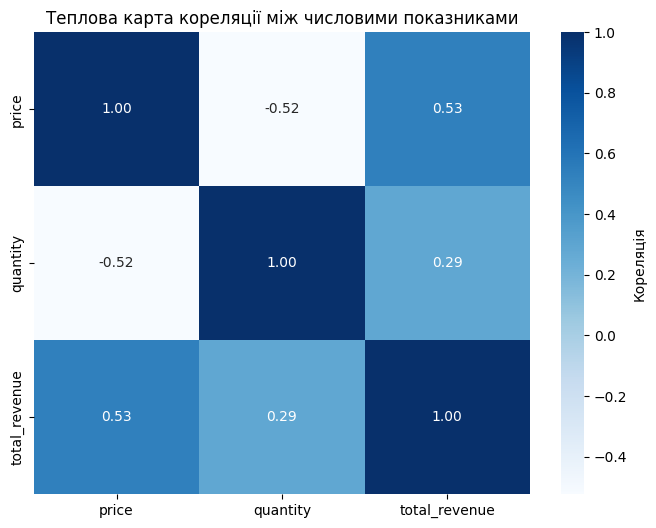

Перевірка category_monthly перед тепловою картою:
category  Category 1  Category 2  Category 3
month                                       
1               35.0        35.0        30.0
2               30.0        80.0         0.0
3               30.0         0.0        25.0
4               40.0        49.0         0.0
5                0.0       100.0        18.0
6                0.0        14.0        75.0
7               65.0         0.0         0.0
8                0.0        40.0        12.0
9               60.0        21.0         0.0
10              60.0         0.0       125.0
11               0.0        76.0         0.0
12              20.0         0.0        27.0
category_monthly після виправлення:
category  Category 1  Category 2  Category 3
month                                       
1               35.0        35.0        30.0
2               30.0        80.0         0.0
3               30.0         0.0        25.0
4               40.0        49.0         0.0
5             

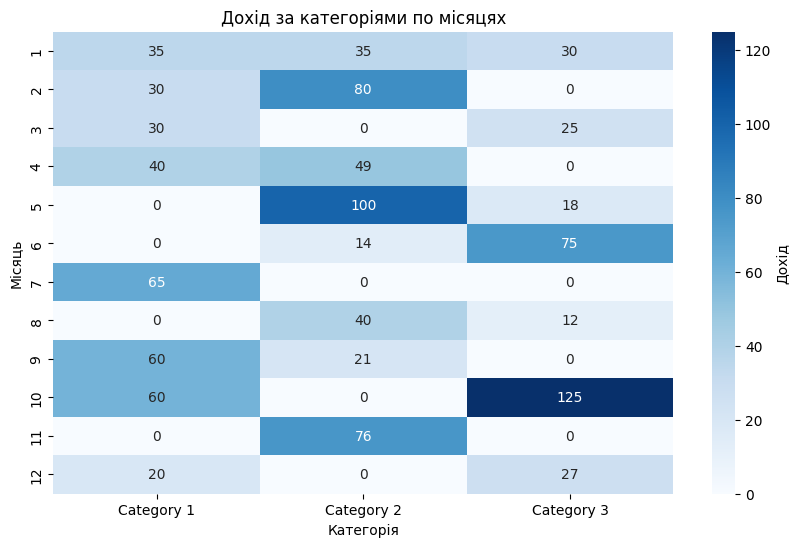

In [35]:
def plot_monthly_trend(monthly_trends):
    """
    + інтерактивний графік тренду доходу за місяцями.
    """
    fig = px.line(monthly_trends, y='Дохід', title='Дохід за місяцями', markers=True)
    fig.update_layout(xaxis_title='Місяць', yaxis_title='Дохід', template='plotly_white', 
                     font=dict(size=12, family="Arial"))
    fig.show()

def plot_category_pie(category_stats):
    """
    + кругову діаграму частки доходу за категоріями.
    """
    fig = px.pie(category_stats, values='total_revenue', names=category_stats.index, 
                 title='Частка доходу за категоріями', color_discrete_sequence=px.colors.sequential.Blues)
    fig.update_traces(textinfo='percent+label')
    fig.show()

def plot_top_products(top_products):
    """
    + стовпчиковий графік топ продуктів за доходом.
    """
    fig = px.bar(top_products, y='total_revenue', x=top_products.index, title='Топ продуктів за доходом', 
                 text=top_products['total_revenue'].round(1), color='total_revenue', 
                 color_continuous_scale='Blues')
    fig.update_traces(textposition='auto')
    fig.update_layout(xaxis_title='Продукт', yaxis_title='Дохід', template='plotly_white', 
                     font=dict(size=12, family="Arial"))
    fig.show()

def plot_category_box(df):
    """
    + бокс-плот для розподілу доходу за категоріями.
    """
    fig = px.box(df, x='category', y='total_revenue', title='Розподіл доходу за категоріями')
    fig.update_layout(xaxis_title='Категорія', yaxis_title='Дохід', template='plotly_white', 
                     font=dict(size=12, family="Arial"))
    fig.show()

def plot_correlation_heatmap(df):
    """
    + теплову карту кореляції між числовими показниками.
    """
    correlation_matrix = df[['price', 'quantity', 'total_revenue']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='Blues', 
               cbar_kws={'label': 'Кореляція'})
    plt.title('Теплова карта кореляції між числовими показниками')
    plt.show()

def plot_category_heatmap(category_monthly):
    """
    + теплову карту доходу за категоріями по місяцях.
    """
    print("Перевірка category_monthly перед тепловою картою:")
    print(category_monthly)

    if (category_monthly < 0).any().any():
        print("Попередження: Знайдено негативні значення в category_monthly. Виправляємо...")
    category_monthly_fixed = category_monthly.clip(lower=0)

    print("category_monthly після виправлення:")
    print(category_monthly_fixed)

    if category_monthly_fixed.sum().sum() == 0:
        print("Критична помилка: Дані для теплової карти порожні. Додайте дані за місяцями та категоріями до файлу MHP.csv.")
        raise ValueError("Дані для теплової карти порожні.")

    plt.figure(figsize=(10, 6))
    sns.heatmap(category_monthly_fixed, annot=True, fmt='.0f', cmap='Blues', 
               cbar_kws={'label': 'Дохід'})
    plt.title('Дохід за категоріями по місяцях')
    plt.xlabel('Категорія')
    plt.ylabel('Місяць')
    plt.show()

def visualize_results(monthly_trends, category_stats, top_products, category_monthly, df):
    """
    Координує всі візуалізації результатів аналізу з обробкою помилок.
    ВАЖЛИВО!!!! Використовує лише дані з файлу MHP.csv.
    """
    try:
        if monthly_trends.empty or category_stats.empty or top_products.empty or category_monthly.empty:
            print("Критична помилка: Недостатньо даних для візуалізації. Додайте більше даних до файлу MHP.csv.")
            raise ValueError("Недостатньо даних для візуалізації.")

        plot_monthly_trend(monthly_trends)
        plot_category_pie(category_stats)
        plot_top_products(top_products)
        plot_category_box(df)
        plot_correlation_heatmap(df)
        plot_category_heatmap(category_monthly)

    except Exception as e:
        print(f"Помилка в візуалізації: {e}")
        raise

# Викликаємо функції
visualize_results(monthly_trends, category_stats, top_products, category_monthly, df)

## 📊 Лінійний графік щомісячного доходу  
Показує зміну доходу протягом року:  
- **Жовтень (185.0)** — найвищий пік, ймовірно, через сезонні фактори (підготовка до свят).  
- **Травень (118.0)** — другий пік, що може вказувати на весняний попит.  
- **Грудень (47.0) та серпень (52.0)** — найнижчі показники.  
- Велика різниця між піками і спадами (майже в 4 рази) свідчить про високу сезонність, що потребує вирівнювання доходу.  

## ⭕️ Кругова діаграма частки доходу за категоріями  
Ілюструє внесок кожної категорії в загальний дохід (**1067.0**):  
- **Category 2** — **38.9% (415.0)**  
- **Category 1** — **31.9% (340.0)**  
- **Category 3** — **29.2% (312.0)**  

Category 2 є ключовим драйвером доходу, але різниця між категоріями не є критичною, що дає змогу працювати з усіма для збалансованого зростання.  

## 📊 Стовпчикова діаграма топ-продуктів за доходом  
Визначає лідерів серед продуктів:  
- **Product E (240.0), Product F (225.0), Product A (220.0)** — головні джерела доходу.  
- **Product D** має найбільшу кількість продажів (**29 одиниць**), але приносить лише **87.0** через низьку ціну (**3.0**).  
- Необхідно переглянути **цінову стратегію** для продуктів із низькою маржинальністю.  

## 📈 Бокс-плот розподілу доходу за категоріями  
Демонструє варіативність транзакцій:  
- **Category 1 та Category 2** — стабільний розподіл доходу (медіана **≈40.0**).  
- **Category 3** — висока варіативність із викидом **125.0 (жовтень)**.  
- Category 3 має потенціал для зростання, але потребує стабілізації.  

## 🔥 Теплова карта кореляції  
Показує взаємозв’язки між основними показниками:  
- **Ціна vs Дохід: 0.53** (позитивна кореляція)  
- **Ціна vs Кількість: -0.52** (негативна кореляція)  
- **Кількість vs Дохід: 0.29** (слабка позитивна кореляція)  
Висновок: **збільшення ціни** може бути ефективнішим для зростання доходу, ніж збільшення кількості продажів.  

## 📅 Теплова карта доходу за категоріями по місяцях  
Підкреслює сезонність кожної категорії:  
- **Category 1**: сильні **липень (65.0), вересень, жовтень (60.0)**, але **0.0 у травні, червні, серпні, листопаді**.  
- **Category 2**: пік у **травні (100.0), лютому (80.0), листопаді (76.0)**, але **0.0 у березні, липні, жовтні**.  
- **Category 3**: максимум у **жовтні (125.0), червні (75.0)**, але **0.0 у лютому, квітні, липні**.  








## 📊 Звіт з аналізу продажів та рекомендації щодо покращення
Я провела детальний аналіз даних продажів із файлу sales_data.csv і підготувала звіт із пропозиціями щодо покращення наших показників. Моя мета полягала в тому, щоб глибоко зануритися в дані, виявити ключові закономірності та запропонувати стратегії, які допоможуть нам оптимізувати доходи та стабілізувати продажі.

**📂 Попередня обробка даних**
Я завантажила дані з файлу mhp_task.csv, перевірила їх на пропуски (їх не виявлено) та аномалії (негативні значення були відсутні), привела колонку date до формату YYYY-MM-DD і додала стовпці month та year для аналізу сезонності. Це дозволило мені підготувати дані для подальшого аналізу.

**💡 Результати аналізу**
На основі проведеного аналізу я виявила кілька важливих закономірностей, які можуть стати основою для наших подальших дій. Загальний дохід за рік склав 1067.0, а середній чек за транзакцію — 41.04, що дає нам уявлення про типовий розмір покупки. Однак дохід розподілений нерівномірно: у жовтні ми досягли максимуму в 185.0, тоді як у грудні зафіксовано мінімум — лише 47.0.

Серед продуктів лідерами за доходом є Product E (240.0) та Product F (225.0), однак їх продається відносно небагато (12 та 9 одиниць відповідно) через високі ціни — 20.0 та 25.0. Натомість Product D, попри найбільшу кількість проданих одиниць (29), приносить лише 87.0 через низьку ціну в 3.0. Цінова динаміка виявилася ключовим фактором: кореляція між ціною та доходом становить 0.53, що свідчить про позитивний вплив підвищення цін на дохід. Водночас кореляція між ціною та кількістю проданих одиниць є негативною (-0.52), тобто зростання цін може зменшувати обсяги продажів.

Щодо категорій, Category 2 є лідером із доходом 415.0 (38.9% від загального), але її продуктивність волатильна — в окремі місяці дохід падає до 0.0. Category 2 виявилася найприбутковішою завдяки стабільно високим продажам у ключові місяці, як травень (100.0), що може свідчити про її популярність серед клієнтів.

**📈 Візуалізації для розуміння тенденцій**
Для кращого розуміння тенденцій я створила кілька графіків: лінійний графік щомісячного доходу показує пік у жовтні (185.0), кругова діаграма ілюструє, що Category 2 приносить 38.9% доходу, а теплова карта доходу за категоріями по місяцях допомагає виявити сильні та слабкі періоди. Також я додала бокс-плот для розподілу доходу за категоріями та теплову карту кореляції, щоб показати взаємозв’язок між ціною, кількістю та доходом.

**💰 Рекомендації щодо цінової стратегії**
На основі отриманих даних я пропоную зосередитися на кількох напрямках у ціновій політиці. Позитивна кореляція між ціною та доходом дає підстави для тестування підвищення цін на високоприбуткові продукти, такі як Product E та Product F, на 10-15%. Наприклад, підвищення ціни Product E з 20.0 до 23.0 може суттєво збільшити дохід, і я рекомендую провести таке тестування протягом наступного місяця, уважно відстежуючи вплив на обсяги продажів.

Крім того, вважаю доцільним запровадити динамічне ціноутворення. У пікові місяці, такі як жовтень та травень, коли попит високий, ми можемо дозволити собі незначне підвищення цін, щоб максимізувати дохід. У слабкі місяці, як грудень та серпень, пропоную знижувати ціни для стимуляції попиту — наприклад, знизити ціну Product D з 3.0 до 2.5 у серпні, щоб залучити більше покупців.

Ще одна стратегія — створення пакетних пропозицій. Product D, який має високу кількість продажів, але низький дохід, може стати основою для пакетів із преміальними продуктами. Наприклад, ми можемо запропонувати клієнтам акцію: "Купіть 5 одиниць Product D за 15.0 та отримайте Product E зі знижкою 10%". Це дозволить нам підняти середній чек і збалансувати продажі.

**📣 Пропозиції щодо маркетингу та продажів**
У сфері маркетингу я бачу можливості для підсилення наших сильних періодів та активізації слабких. Жовтень із доходом 185.0 є нашим найуспішнішим місяцем, і тут особливо виділяється Category 3 (125.0). Я пропоную запустити в цей період цільову кампанію для Category 3 — наприклад, акцію "Придбайте два продукти з Category 3 та отримайте знижку 15% на другий". У травні, коли Category 2 досягає 100.0, ми можемо провести тематичну кампанію, як-от "Весняне оновлення з Category 2", із акцентом на продукти типу Product E.

Слабкі місяці потребують особливої уваги. Грудень із доходом лише 47.0 є несподівано низьким для святкового періоду. Я рекомендую запровадити святкові знижки або програму лояльності — наприклад, "Зробіть покупку на 50.0 у грудні та отримайте бонус на січень". Це може підняти середній чек із 23.5 до щонайменше 40.0. У серпні, коли дохід становить 52.0, пропоную організувати літній розпродаж із гаслом "Останній шанс літа — знижки до 20% на Category 1".

Додатково я пропоную розглянути крос-категорійні акції. У жовтні сильні позиції мають Category 1 (60.0) та Category 3 (125.0). Ми можемо запропонувати знижки на комплекти з продуктів цих категорій — наприклад, "Придбайте Product A з Category 1 та Product F з Category 3 разом і заощадьте 10%". Такий підхід заохотить клієнтів купувати більше та спробувати продукти з різних категорій.

**🏢 Операційні вдосконалення для підвищення ефективності**
На операційному рівні я виявила кілька аспектів, які потребують уваги. По-перше, пропоную оптимізувати управління запасами. У жовтні Category 3 генерує 125.0 доходу, а в травні Category 2 — 100.0. У ці місяці необхідно збільшити запаси саме цих категорій, щоб ми могли повною мірою скористатися попитом. Натомість у слабкі місяці, як грудень, запаси варто зменшити, щоб уникнути надлишків — наприклад, Category 2 у грудні приносить 0.0, тож великий запас тут недоцільний.

По-друге, я звернула увагу на нульові доходи в певні місяці, зокрема Category 1 у травні (0.0). Рекомендую дослідити причини: якщо це пов’язано з браком запасів, варто вдосконалити ланцюг постачання; якщо ж попит відсутній, можливо, доцільно переглянути асортимент і зосередитися на більш затребуваних продуктах.

Нарешті, я пропоную звернути увагу на стабільність Category 2. У травні вона досягла 100.0, але в інші місяці її продуктивність дуже волатильна (наприклад, 0.0 у липні). Я рекомендую проаналізувати, що саме спричинило успіх у травні — чи це була вдала акція, чи сезонний попит, — і застосувати ці підходи в інші місяці, щоб зменшити волатильність.

**🌟 Висновки та рекомендації**
Проведений аналіз дає чітке уявлення про поточний стан продажів. Загальний дохід за рік склав 1067.0, але ми спостерігаємо значну нерівномірність: пікові місяці, як жовтень (185.0) та травень (118.0), контрастують із слабкими періодами, такими як грудень (47.0) та серпень (52.0). Середній чек становить 41.04, що свідчить про помірний розмір типової покупки. Лідерами за доходом є продукти E (240.0) та F (225.0), але вони продаються в обмежених кількостях через високі ціни, тоді як Product D із найбільшою кількістю продажів (29 одиниць) приносить лише 87.0 через низьку ціну. Category 2 є найприбутковішою (415.0, 38.9% від загального доходу), але її волатильність потребує уваги. Позитивна кореляція між ціною та доходом (0.53) вказує на потенціал для зростання доходу через підвищення цін, хоча це може зменшити кількість продажів (-0.52 кореляція між ціною та кількістю).

На основі цих висновків я пропоную кілька стратегій для покращення продажів. Щодо цін, рекомендую протестувати підвищення цін на продукти E та F на 10-15%, наприклад, піднявши ціну Product E з 20.0 до 23.0, і відстежити вплив на обсяги продажів. Також варто запровадити динамічне ціноутворення: підвищувати ціни в пікові місяці (жовтень, травень) і знижувати в слабкі (грудень, серпень), наприклад, знизивши ціну Product D до 2.5 у серпні. Для підвищення середнього чеку пропоную створювати пакети: наприклад, "Купіть 5 одиниць Product D за 15.0 та отримайте Product E зі знижкою 10%".

У маркетингу я бачу можливості для підсилення сильних періодів та активізації слабких. У жовтні варто запустити кампанію для Category 3 ("Придбайте два продукти з Category 3 та отримайте знижку 15%"), а в травні — для Category 2 ("Весняне оновлення з Category 2"). У грудні, щоб підняти дохід із 47.0, пропоную святкові знижки ("Зробіть покупку на 50.0 та отримайте бонус на січень"), а в серпні — літній розпродаж ("Знижки до 20% на Category 1"). Крос-категорійні акції, як-от знижки на комплекти з Category 1 та 3 у жовтні, також можуть стимулювати продажі.

Операційно рекомендую оптимізувати запаси: збільшувати їх для Category 3 у жовтні та Category 2 у травні, зменшувати в слабкі місяці, як грудень. Нульові доходи, наприклад, Category 1 у травні, потребують аналізу причин — можливо, варто вдосконалити постачання або переглянути асортимент.

Ці рекомендації дозволять не лише підняти дохід, а й зробити продажі більш стабільними протягом року, що сприятиме довгостроковому зростанню.